In [1]:
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:576: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)


In [2]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = ExactGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.2), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.05, 0.3), "noise")

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    model.pyro_sample_from_prior()
    output = model(x)
    loss = mll.pyro_factor(output, y)
    return y

nuts_kernel = NUTS(pyro_model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc_run.run(train_x, train_y)

sample: 100%|██████████| 300/300 [00:19, 15.61it/s, step size=7.26e-01, acc. prob=0.850]


In [5]:
model.pyro_load_from_samples(mcmc_run.get_samples())

In [12]:
model.eval()
expanded_train_x = train_x.unsqueeze(-1).repeat(100, 1, 1)
output = model(expanded_train_x)

/mnt/c/Users/Gardn/gpytorch/gpytorch/models/exact_gp.py:256: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


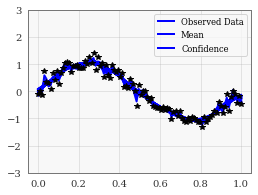

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot predictive means as blue line
    for i in range(25):
        ax.plot(train_x.numpy(), output.mean[i].detach().numpy(), 'b')
        
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)
    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])